In [67]:
from google.colab import files
uploaded = files.upload()

Saving feedback_data.csv to feedback_data.csv


KAVIYA V - 24MAI0077

root
 |-- Customer ID: string (nullable = true)
 |-- Feedback Channel: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Comment: string (nullable = true)
 |-- Date: date (nullable = true)

+--------------------+-----+
|    Customer Segment|count|
+--------------------+-----+
|     Loyal Customers|   15|
|   Neutral Customers|   79|
|Dissatisfied Cust...|    6|
+--------------------+-----+



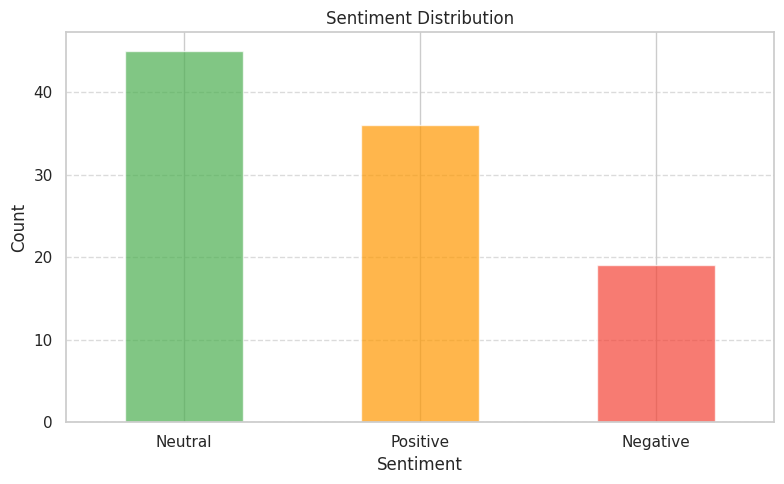

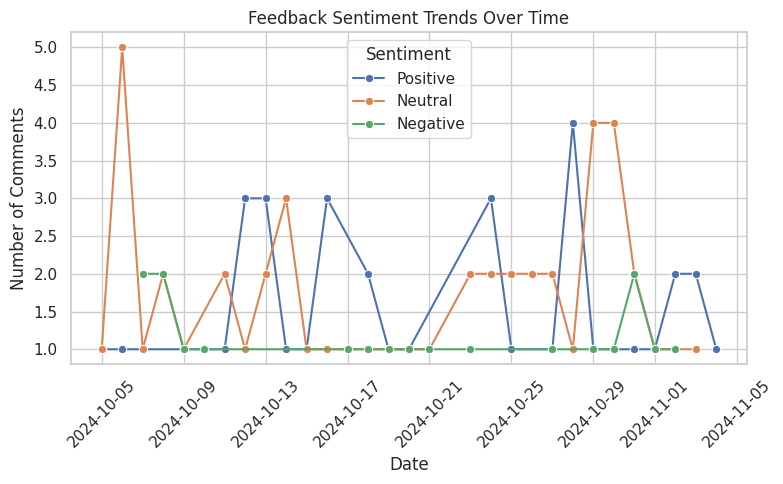

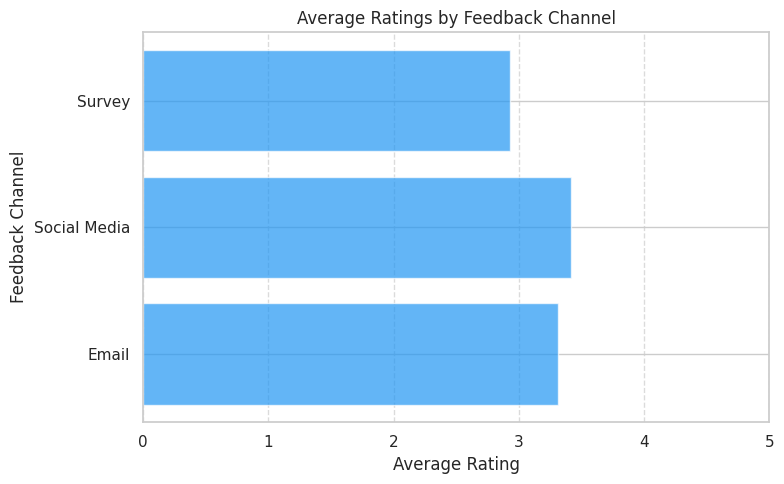

In [70]:
print("KAVIYA V - 24MAI0077\n")

# Import Necessary Libraries
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import col, lower, regexp_replace, udf, when, count, avg, to_date
from pyspark.sql.types import StringType
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Spark Session
spark = SparkSession.builder \
    .appName("Customer Feedback Analysis") \
    .getOrCreate()

# Data Ingestion
feedback_df = spark.read.csv("feedback_data.csv", header=True, inferSchema=True)
feedback_df.printSchema()

# Data Cleaning
feedback_df = feedback_df.withColumn("Cleaned_Comment", lower(col("Comment")))
feedback_df = feedback_df.withColumn("Cleaned_Comment", regexp_replace(col("Cleaned_Comment"), "[^a-zA-Z0-9 ]", ""))
feedback_df = feedback_df.fillna({"Comment": "No comment provided", "Rating": 3})
feedback_df = feedback_df.fillna({"Cleaned_Comment": ""})

# Sentiment Analysis
def get_sentiment(text):
    if text is None or text == "":
        return "Neutral"
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity == 0:
        return "Neutral"
    else:
        return "Negative"

sentiment_udf = udf(get_sentiment, StringType())
feedback_df = feedback_df.withColumn("Sentiment", sentiment_udf(col("Cleaned_Comment")))
feedback_df = feedback_df.withColumn("Customer Segment",
    when((col("Rating") >= 4) & (col("Sentiment") == "Positive"), "Loyal Customers")
    .when((col("Rating") <= 2) & (col("Sentiment") == "Negative"), "Dissatisfied Customers")
    .otherwise("Neutral Customers")
)
customer_segment_counts = feedback_df.groupBy("Customer Segment").count()
customer_segment_counts.show()
feedback_df.write.csv("cleaned_feedback.csv", header=True)

# Trend Analysis
feedback_df = feedback_df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))
trend_df = feedback_df.groupBy("Date", "Sentiment").agg(count("Sentiment").alias("Sentiment Count"))
channel_sentiment_df = feedback_df.groupBy("Feedback Channel", "Sentiment").agg(count("Sentiment").alias("Sentiment Count"))
channel_avg_rating_df = feedback_df.groupBy("Feedback Channel").agg(avg("Rating").alias("Average Rating"))

trend_pandas = trend_df.toPandas()
channel_sentiment_pandas = channel_sentiment_df.toPandas()
channel_avg_rating_pandas = channel_avg_rating_df.toPandas()

# Data Visualization
# Sentiment Distribution
sentiment_counts = feedback_df.select("Sentiment").toPandas()['Sentiment'].value_counts()
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['#4CAF50', '#FF9800', '#F44336'], alpha=0.7)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Feedback Trends Over Time
trend_pandas = trend_df.toPandas()
trend_pandas['Date'] = pd.to_datetime(trend_pandas['Date'])
plt.figure(figsize=(8, 5))
sns.lineplot(data=trend_pandas, x="Date", y="Sentiment Count", hue="Sentiment", marker='o')
plt.title("Feedback Sentiment Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# Average Ratings by Channel
average_ratings = channel_avg_rating_df.toPandas()
plt.figure(figsize=(8, 5))
plt.barh(average_ratings['Feedback Channel'], average_ratings['Average Rating'], color='#2196F3', alpha=0.7)
plt.title('Average Ratings by Feedback Channel')
plt.xlabel('Average Rating')
plt.ylabel('Feedback Channel')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, 5)
plt.tight_layout()
plt.show()

spark.stop()
